=== Step 1: Simulate GBM paths (shared for all families) ===
=== Step 2: Compute path-dependent payoffs ===
=== Step 3: Run experiments for each sigmoidal family ===

##############################
Running experiment for sigmoid family: tanh
##############################
Trial   1/20: family=tanh, theta = (V=1.958, k_move=8.820, k_level=5.827), J = -33.7630
Trial   2/20: family=tanh, theta = (V=1.547, k_move=23.886, k_level=9.461), J = -42.5702
Trial   3/20: family=tanh, theta = (V=1.062, k_move=7.386, k_level=7.688), J = -31.1911
Trial   4/20: family=tanh, theta = (V=0.958, k_move=9.868, k_level=8.209), J = -31.8827
Trial   5/20: family=tanh, theta = (V=1.877, k_move=21.426, k_level=9.611), J = -43.9232
Trial   6/20: family=tanh, theta = (V=1.592, k_move=8.034, k_level=6.785), J = -32.2725
Trial   7/20: family=tanh, theta = (V=1.859, k_move=7.788, k_level=4.293), J = -33.1185
Trial   8/20: family=tanh, theta = (V=1.990, k_move=9.999, k_level=10.290), J = -34.2610
Trial   9/20: family

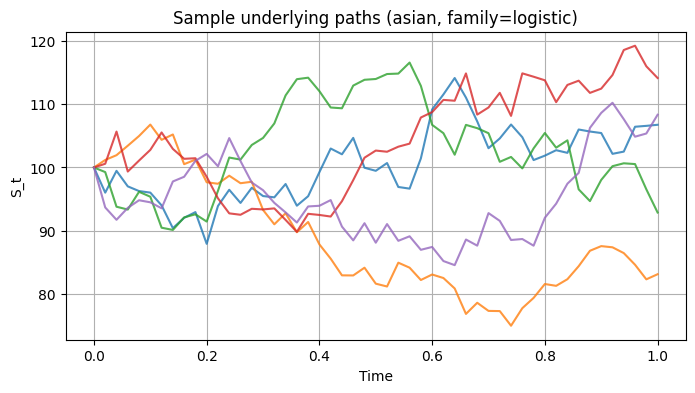

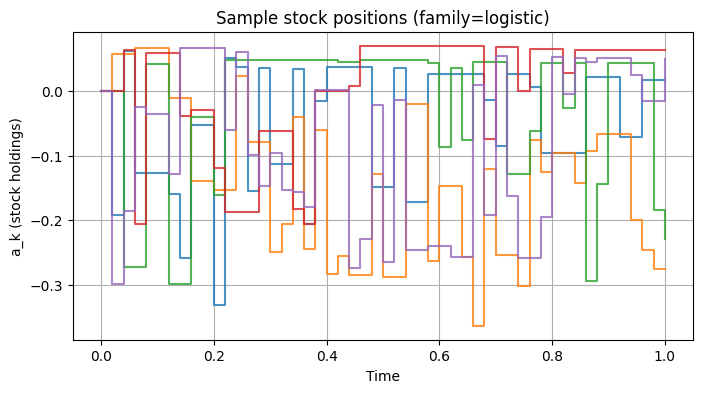

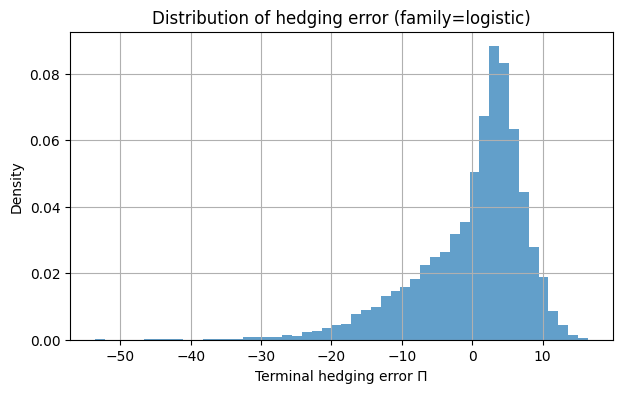

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List, Dict
from math import erf

# ============================================
# ΒΟΗΘΗΤΙΚΑ: erf για numpy arrays
# ============================================
erf_vec = np.vectorize(erf, otypes=[float])

# Για αναπαραγωγιμότητα σε όλα τα πειράματα
rng = np.random.default_rng(seed=12345)

# ============================================
# 1. Geometric Brownian Motion paths
# ============================================

def simulate_gbm_paths(
    S0: float,
    mu: float,
    sigma: float,
    T: float,
    n_steps: int,
    n_paths: int,
    rng: Optional[np.random.Generator] = None,
) -> np.ndarray:
    """Simulate GBM paths (Euler in log-space)."""
    if rng is None:
        rng = np.random.default_rng()
    dt = T / n_steps
    Z = rng.standard_normal(size=(n_paths, n_steps))
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * Z
    log_S_increments = drift + diffusion
    log_S = np.cumsum(log_S_increments, axis=1)
    log_S = np.concatenate(
        [np.full((n_paths, 1), np.log(S0)), log_S + np.log(S0)],
        axis=1
    )
    S = np.exp(log_S)
    return S

# ============================================
# 2. Path-dependent payoffs (Asian / Lookback)
# ============================================

def asian_arithmetic_call(S_paths: np.ndarray, K: float) -> np.ndarray:
    """Arithmetic Asian call payoff."""
    avg_price = S_paths[:, 1:].mean(axis=1)
    return np.maximum(avg_price - K, 0.0)

def lookback_fixed_strike_call(S_paths: np.ndarray, K: float) -> np.ndarray:
    """Lookback call with fixed strike."""
    s_max = S_paths.max(axis=1)
    return np.maximum(s_max - K, 0.0)
# ============================================
# 3. Sigmoidal functions (tanh, logistic, N(d))
# ============================================

from scipy.stats import norm

def logistic_sigmoid(x: np.ndarray, k: float = 1.0, x0: float = 0.0) -> np.ndarray:
    """
    Logistic σ(x) = 1 / (1 + exp(-k (x - x0))) με range (0, 1).
    Βάση για να φτιάξουμε εκδοχή στο [-1, 1] αν χρειαστεί.
    """
    x = np.asarray(x, dtype=float)
    return 1.0 / (1.0 + np.exp(-k * (x - x0)))


def normal_cdf_sigmoid(x: np.ndarray, k: float = 1.0, x0: float = 0.0) -> np.ndarray:
    """
    Normal CDF / N(d) sigmoid με range (0, 1):
        N(k (x - x0)).
    """
    x = np.asarray(x, dtype=float)
    return norm.cdf(k * (x - x0))


def sigmoid_tanh_pm1(x: np.ndarray, k: float = 1.0, x0: float = 0.0) -> np.ndarray:
    """
    tanh-based sigmoid στο [-1, 1]:
        σ(x) = tanh(k (x - x0)).
    """
    x = np.asarray(x, dtype=float)
    return np.tanh(k * (x - x0))


def sigmoid_logistic_pm1(x: np.ndarray, k: float = 1.0, x0: float = 0.0) -> np.ndarray:
    """
    Logistic-based sigmoid rescaled στο [-1, 1]:
        σ_pm1(x) = 2 * logistic_sigmoid(x; k, x0) - 1.
    """
    x = np.asarray(x, dtype=float)
    s01 = logistic_sigmoid(x, k=k, x0=x0)   # in (0, 1)
    return 2.0 * s01 - 1.0                  # in (-1, 1)


def sigmoid_normal_pm1(x: np.ndarray, k: float = 1.0, x0: float = 0.0) -> np.ndarray:
    """
    Normal CDF / N(d)-based sigmoid rescaled στο [-1, 1]:
        σ_pm1(x) = 2 * N(k (x - x0)) - 1.
    """
    x = np.asarray(x, dtype=float)
    s01 = normal_cdf_sigmoid(x, k=k, x0=x0)  # in (0, 1)
    return 2.0 * s01 - 1.0                   # in (-1, 1)


def sigmoid_signal(
    x: np.ndarray,
    family: str = "tanh",
    k: float = 1.0,
    x0: float = 0.0,
) -> np.ndarray:
    """
    Ενοποιημένο interface που ΠΑΝΤΑ επιστρέφει τιμές στο [-1, 1].

    - family = "tanh"     -> tanh-based σ στο [-1, 1]
    - family = "logistic" -> logistic-based σ στο [-1, 1]
    - family = "normal"   -> N(d)-based σ στο [-1, 1]
    """
    family = family.lower()
    x = np.asarray(x, dtype=float)

    if family == "tanh":
        return sigmoid_tanh_pm1(x, k=k, x0=x0)
    elif family == "logistic":
        return sigmoid_logistic_pm1(x, k=k, x0=x0)
    elif family in ("normal", "gaussian", "nd"):
        return sigmoid_normal_pm1(x, k=k, x0=x0)
    else:
        raise ValueError(f"Unknown sigmoid family: {family}")








# ============================================
# 4. Dynamic hedging με sigmoidal κανόνα
# ============================================

def run_sigmoidal_hedge_underlying_only(
    S_paths: np.ndarray,
    payoff: np.ndarray,
    Y: float,
    L: float = 2.0,
    M: float = 2.0,
    V: float = 1.0,
    z1: float = 0.02,
    z2: float = 0.02,
    q1: float = 0.0,
    q2: float = 0.7,
    q3: float = 0.3,
    k_move: float = 10.0,
    k_level: float = 5.0,
    sigmoid_move: str = "tanh",
    sigmoid_level: str = "tanh",
) -> Dict[str, np.ndarray]:
    """
    Hedging μόνο με underlying.
    Sigmoid family για 'move' και 'level' μπορεί να είναι διαφορετική.
    """
    n_paths, n_steps_plus_1 = S_paths.shape
    N = n_steps_plus_1 - 1
    S0 = S_paths[0, 0]

    # αρχικές θέσεις
    a0 = 0.0
    b0 = Y
    a = np.zeros((n_paths, N + 1))
    b = np.zeros((n_paths, N + 1))
    a[:, 0] = a0
    b[:, 0] = b0

    def A_next_func(a_k: np.ndarray, b_k: np.ndarray, S_next: np.ndarray) -> np.ndarray:
        return (a_k * S_next + b_k + M) / S_next

    for k in range(N):
        S_k = S_paths[:, k]
        S_next = S_paths[:, k + 1]
        a_k = a[:, k]
        b_k = b[:, k]

        # relative move
        rel_move = (S_next - S_k) / S_k
        sig_move = sigmoid_signal(rel_move, family=sigmoid_move, k=k_move, x0=0.0)

        # level signal (log-moneyness)
        level = np.log(S_next / S0)
        sig_level = sigmoid_signal(level, family=sigmoid_level, k=k_level, x0=0.0)

        z1_k = V * sig_move
        z2_k = V * sig_level

        trigger = (rel_move > z1) | (rel_move < -z2)

        tilde_a_next = np.where(
            trigger,
            q1 * a_k + q2 * z1_k + q3 * z2_k,
            a_k,
        )

        A_next = A_next_func(a_k, b_k, S_next)
        a_next = np.clip(tilde_a_next, -L, A_next)
        b_next = b_k - (a_next - a_k) * S_next

        a[:, k + 1] = a_next
        b[:, k + 1] = b_next

    S_T = S_paths[:, -1]
    W_T = a[:, -1] * S_T + b[:, -1]
    hedging_error = W_T - payoff
    loss = -hedging_error

    return {
        "a": a,
        "b": b,
        "S_paths": S_paths,
        "W_T": W_T,
        "payoff": payoff,
        "hedging_error": hedging_error,
        "loss": loss,
    }

# ============================================
# 5. VaR, CVaR, mean–CVaR objective
# ============================================

def var_cvar(losses: np.ndarray, alpha: float = 0.99) -> Tuple[float, float]:
    """Εκτίμηση empirical VaR και CVaR στο επίπεδο alpha."""
    losses = np.asarray(losses)
    sorted_losses = np.sort(losses)
    n = len(sorted_losses)
    idx = int(np.floor(alpha * n)) - 1
    idx = max(0, min(idx, n - 1))
    var_alpha = sorted_losses[idx]
    tail_losses = sorted_losses[idx:]
    cvar_alpha = tail_losses.mean() if len(tail_losses) > 0 else var_alpha
    return float(var_alpha), float(cvar_alpha)

def mean_cvar_objective(
    hedging_error: np.ndarray,
    alpha: float = 0.99,
    lam: float = 1.0,
) -> float:
    """
    J = E[Π] - λ * CVaR_α(loss),
    όπου loss = -Π.
    """
    Pi = np.asarray(hedging_error)
    L = -Pi
    _, cvar_alpha = var_cvar(L, alpha=alpha)
    return float(Pi.mean() - lam * cvar_alpha)

# ============================================
# 6. Αξιολόγηση παραμέτρων & Random search
# ============================================

def evaluate_theta(
    theta: Tuple[float, float, float],
    S_paths: np.ndarray,
    payoff: np.ndarray,
    alpha: float = 0.99,
    lam: float = 1.0,
    L: float = 2.0,
    M: float = 2.0,
    z1: float = 0.01,
    z2: float = 0.01,
    q1: float = 0.0,
    q2: float = 0.8,
    q3: float = 0.2,
    sigmoid_move: str = "tanh",
    sigmoid_level: str = "tanh",
) -> float:
    """Υπολογίζει J(θ) για συγκεκριμένο (V, k_move, k_level)."""
    V, k_move, k_level = theta
    Y = float(payoff.mean())
    results = run_sigmoidal_hedge_underlying_only(
        S_paths=S_paths,
        payoff=payoff,
        Y=Y,
        L=L,
        M=M,
        V=V,
        z1=z1,
        z2=z2,
        q1=q1,
        q2=q2,
        q3=q3,
        k_move=k_move,
        k_level=k_level,
        sigmoid_move=sigmoid_move,
        sigmoid_level=sigmoid_level,
    )
    hedging_error = results["hedging_error"]
    J_theta = mean_cvar_objective(hedging_error, alpha=alpha, lam=lam)
    return J_theta

def random_search_sigmoidal_params(
    S_paths: np.ndarray,
    payoff: np.ndarray,
    alpha: float = 0.99,
    lam: float = 1.0,
    n_trials: int = 50,
    V_range: Tuple[float, float] = (0.5, 2.0),
    k_move_range: Tuple[float, float] = (5.0, 25.0),
    k_level_range: Tuple[float, float] = (2.0, 15.0),
    sigmoid_move: str = "tanh",
    sigmoid_level: str = "tanh",
) -> Tuple[Tuple[float, float, float], List[Dict[str, object]]]:
    """
    Απλό random search για (V, k_move, k_level) για συγκεκριμένη οικογένεια.
    """
    best_J = -np.inf
    best_theta: Optional[Tuple[float, float, float]] = None
    history: List[Dict[str, object]] = []

    for trial in range(n_trials):
        V = rng.uniform(*V_range)
        k_move = rng.uniform(*k_move_range)
        k_level = rng.uniform(*k_level_range)
        theta = (V, k_move, k_level)

        J_theta = evaluate_theta(
            theta, S_paths, payoff,
            alpha=alpha, lam=lam,
            sigmoid_move=sigmoid_move,
            sigmoid_level=sigmoid_level,
        )

        history.append({"theta": theta, "J": J_theta})

        if J_theta > best_J:
            best_J = J_theta
            best_theta = theta

        print(
            f"Trial {trial+1:3d}/{n_trials}: "
            f"family={sigmoid_move}, "
            f"theta = (V={V:.3f}, k_move={k_move:.3f}, k_level={k_level:.3f}), "
            f"J = {J_theta:.4f}"
        )

    print("\n=== Best parameters for family", sigmoid_move, "===")
    if best_theta is not None:
        V, k_move, k_level = best_theta
        print(f"V = {V:.4f}, k_move = {k_move:.4f}, k_level = {k_level:.4f}")
        print(f"Best J = {best_J:.4f}")
    else:
        print("No parameter found (this should not happen).")

    return best_theta, history

# ============================================
# 7. Πείραμα για μία οικογένεια sigmoids
# ============================================

def run_experiment_for_family(
    S_paths: np.ndarray,
    payoff: np.ndarray,
    payoff_type: str,
    family: str,
    alpha: float = 0.99,
    lam: float = 1.0,
    n_trials: int = 30,
) -> Tuple[Dict[str, np.ndarray], Dict[str, float], List[Dict[str, object]]]:
    print("\n##############################")
    print(f"Running experiment for sigmoid family: {family}")
    print("##############################")

    best_theta, history = random_search_sigmoidal_params(
        S_paths=S_paths,
        payoff=payoff,
        alpha=alpha,
        lam=lam,
        n_trials=n_trials,
        sigmoid_move=family,
        sigmoid_level=family,
    )

    if best_theta is None:
        raise RuntimeError("random_search_sigmoidal_params did not return a best_theta.")

    V_best, k_move_best, k_level_best = best_theta
    Y_best = float(payoff.mean())

    results_best = run_sigmoidal_hedge_underlying_only(
        S_paths=S_paths,
        payoff=payoff,
        Y=Y_best,
        L=2.0,
        M=2.0,
        V=V_best,
        z1=0.01,
        z2=0.01,
        q1=0.0,
        q2=0.8,
        q3=0.2,
        k_move=k_move_best,
        k_level=k_level_best,
        sigmoid_move=family,
        sigmoid_level=family,
    )

    hedging_error_best = results_best["hedging_error"]
    loss_best = -hedging_error_best

    mean_Pi = float(hedging_error_best.mean())
    std_Pi = float(hedging_error_best.std(ddof=1))
    var_a, cvar_a = var_cvar(loss_best, alpha=alpha)
    J_best = mean_cvar_objective(hedging_error_best, alpha=alpha, lam=lam)

    print("\nStatistics for family", family)
    print(f"Initial price estimate Y          = {Y_best:.4f}")
    print(f"Mean hedging error E[Π]           = {mean_Pi:.4f}")
    print(f"Std of hedging error              = {std_Pi:.4f}")
    print(f"VaR_{alpha:.2f}(loss)               = {var_a:.4f}")
    print(f"CVaR_{alpha:.2f}(loss)              = {cvar_a:.4f}")
    print(f"Mean–CVaR objective J             = {J_best:.4f}")

    summary = {
        "family": family,
        "Y": Y_best,
        "mean_Pi": mean_Pi,
        "std_Pi": std_Pi,
        "VaR_alpha": var_a,
        "CVaR_alpha": cvar_a,
        "J": J_best,
        "V_best": V_best,
        "k_move_best": k_move_best,
        "k_level_best": k_level_best,
    }

    return results_best, summary, history

# ============================================
# 8. Σύγκριση όλων των οικογενειών
# ============================================

def compare_sigmoid_families(
    n_paths_opt: int = 10000,
    n_steps: int = 50,
    S0: float = 100.0,
    K: float = 100.0,
    T: float = 1.0,
    mu: float = 0.0,
    sigma: float = 0.2,
    alpha: float = 0.99,
    lam: float = 1.0,
    payoff_type: str = "asian",  # ή "lookback"
    n_trials: int = 20,
    families: List[str] = None,
):
    if families is None:
        families = ["tanh", "logistic", "normal"]

    print("=== Step 1: Simulate GBM paths (shared for all families) ===")
    S_paths_opt = simulate_gbm_paths(
        S0=S0,
        mu=mu,
        sigma=sigma,
        T=T,
        n_steps=n_steps,
        n_paths=n_paths_opt,
        rng=rng,
    )

    print("=== Step 2: Compute path-dependent payoffs ===")
    if payoff_type.lower() == "asian":
        payoff_opt = asian_arithmetic_call(S_paths_opt, K=K)
    elif payoff_type.lower() == "lookback":
        payoff_opt = lookback_fixed_strike_call(S_paths_opt, K=K)
    else:
        raise ValueError("payoff_type must be 'asian' or 'lookback'.")

    all_summaries = {}
    all_histories = {}
    all_results = {}
    best_overall_J = -np.inf
    best_family = None
    best_results = None

    print("=== Step 3: Run experiments for each sigmoidal family ===")
    for fam in families:
        results_fam, summary_fam, history_fam = run_experiment_for_family(
            S_paths=S_paths_opt,
            payoff=payoff_opt,
            payoff_type=payoff_type,
            family=fam,
            alpha=alpha,
            lam=lam,
            n_trials=n_trials,
        )
        all_summaries[fam] = summary_fam
        all_histories[fam] = history_fam
        all_results[fam] = results_fam

        if summary_fam["J"] > best_overall_J:
            best_overall_J = summary_fam["J"]
            best_family = fam
            best_results = results_fam

    print("\n=== Comparison of families (by J) ===")
    for fam in families:
        s = all_summaries[fam]
        print(
            f"family={fam:8s}  "
            f"J={s['J']:.4f},  "
            f"E[Π]={s['mean_Pi']:.4f},  "
            f"CVaR={s['CVaR_alpha']:.4f}"
        )

    print("\nBest overall family:", best_family, "with J =", best_overall_J)
    return best_family, best_results, all_summaries, all_histories

# ============================================
# 9. Plots για την καλύτερη οικογένεια
# ============================================

def plot_best_family_results(
    best_family: str,
    best_results: Dict[str, np.ndarray],
    T: float,
    payoff_type: str,
    n_show_paths: int = 5,
):
    S_paths = best_results["S_paths"]
    a = best_results["a"]
    hedging_error = best_results["hedging_error"]

    n_paths, n_steps_plus_1 = S_paths.shape
    n_steps = n_steps_plus_1 - 1
    time_grid = np.linspace(0.0, T, n_steps + 1)

    print("\n=== Plots for best family:", best_family, "===")

    # Υποκείμενη τιμή
    plt.figure(figsize=(8, 4))
    for i in range(min(n_show_paths, n_paths)):
        plt.plot(time_grid, S_paths[i], alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("S_t")
    plt.title(f"Sample underlying paths ({payoff_type}, family={best_family})")
    plt.grid(True)
    plt.show()

    # Θέσεις στο υπόκειμενο
    plt.figure(figsize=(8, 4))
    for i in range(min(n_show_paths, n_paths)):
        plt.step(time_grid, a[i], where="post", alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("a_k (stock holdings)")
    plt.title(f"Sample stock positions (family={best_family})")
    plt.grid(True)
    plt.show()

    # Κατανομή hedging error
    plt.figure(figsize=(7, 4))
    plt.hist(hedging_error, bins=50, density=True, alpha=0.7)
    plt.xlabel("Terminal hedging error Π")
    plt.ylabel("Density")
    plt.title(f"Distribution of hedging error (family={best_family})")
    plt.grid(True)
    plt.show()

# ============================================
# 10. Main (τρέχει τα πειράματα και τη σύγκριση)
# ============================================

if __name__ == "__main__":
    best_family, best_results, all_summaries, all_histories = compare_sigmoid_families(
        n_paths_opt=10000,  # αύξησέ το αν θες πιο “smooth” στατιστικά
        n_steps=50,
        S0=100.0,
        K=100.0,
        T=1.0,
        mu=0.0,
        sigma=0.2,
        alpha=0.99,
        lam=1.0,
        payoff_type="asian",   # "asian" ή "lookback"
        n_trials=20,           # αύξησέ το για πιο εντατική αναζήτηση
    )

    print("\nSummary (best family only):")
    for k, v in all_summaries[best_family].items():
        if isinstance(v, float):
            print(f"{k}: {v:.6f}")
        else:
            print(f"{k}: {v}")

    plot_best_family_results(
        best_family=best_family,
        best_results=best_results,
        T=1.0,
        payoff_type="asian",
    )


=== Step 1: Simulate GBM paths (shared for all families) ===
=== Step 2: Compute path-dependent payoffs ===
=== Step 3: Run experiments for each sigmoidal family ===

##############################
Running experiment for sigmoid family: tanh
##############################
Trial   1/20: family=tanh, theta = (V=1.958, k_move=8.820, k_level=5.827), J = -33.7630
Trial   2/20: family=tanh, theta = (V=1.547, k_move=23.886, k_level=9.461), J = -42.5702
Trial   3/20: family=tanh, theta = (V=1.062, k_move=7.386, k_level=7.688), J = -31.1911
Trial   4/20: family=tanh, theta = (V=0.958, k_move=9.868, k_level=8.209), J = -31.8827
Trial   5/20: family=tanh, theta = (V=1.877, k_move=21.426, k_level=9.611), J = -43.9232
Trial   6/20: family=tanh, theta = (V=1.592, k_move=8.034, k_level=6.785), J = -32.2725
Trial   7/20: family=tanh, theta = (V=1.859, k_move=7.788, k_level=4.293), J = -33.1185
Trial   8/20: family=tanh, theta = (V=1.990, k_move=9.999, k_level=10.290), J = -34.2610
Trial   9/20: family

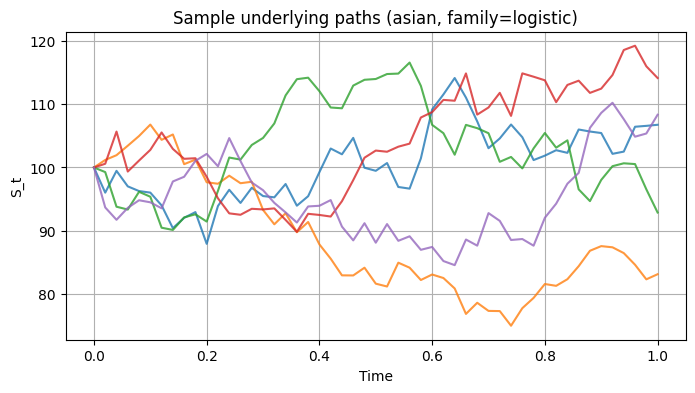

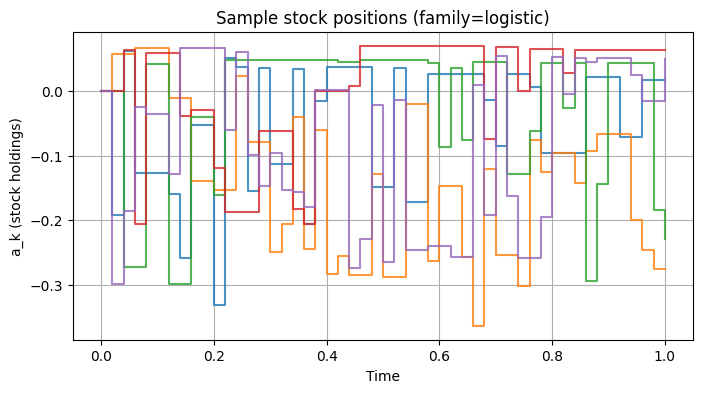

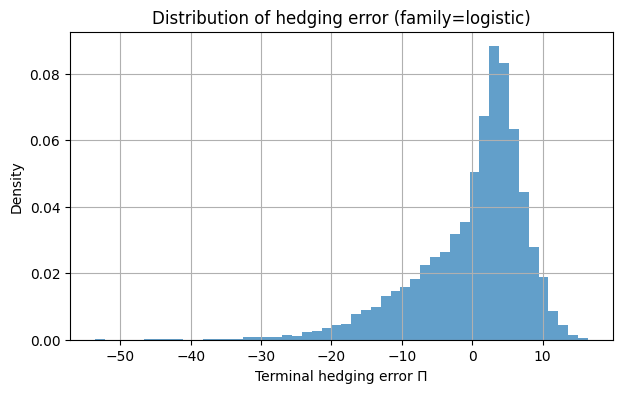

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List, Dict
from math import erf

from scipy.stats import norm

# ============================================
# ΒΟΗΘΗΤΙΚΑ: erf για numpy arrays
# ============================================
erf_vec = np.vectorize(erf, otypes=[float])

# Για αναπαραγωγιμότητα σε όλα τα πειράματα
rng = np.random.default_rng(seed=12345)

# ============================================
# 1. Geometric Brownian Motion paths
# ============================================

def simulate_gbm_paths(
    S0: float,
    mu: float,
    sigma: float,
    T: float,
    n_steps: int,
    n_paths: int,
    rng: Optional[np.random.Generator] = None,
) -> np.ndarray:
    """Simulate GBM paths (Euler in log-space)."""
    if rng is None:
        rng = np.random.default_rng()
    dt = T / n_steps
    Z = rng.standard_normal(size=(n_paths, n_steps))
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * Z
    log_S_increments = drift + diffusion
    log_S = np.cumsum(log_S_increments, axis=1)
    log_S = np.concatenate(
        [np.full((n_paths, 1), np.log(S0)), log_S + np.log(S0)],
        axis=1
    )
    S = np.exp(log_S)
    return S

# ============================================
# 2. Path-dependent payoffs (Asian / Lookback)
# ============================================

def asian_arithmetic_call(S_paths: np.ndarray, K: float) -> np.ndarray:
    """Arithmetic Asian call payoff."""
    # Average από t1,...,tN (όχι το αρχικό S0)
    avg_price = S_paths[:, 1:].mean(axis=1)
    return np.maximum(avg_price - K, 0.0)

def lookback_fixed_strike_call(S_paths: np.ndarray, K: float) -> np.ndarray:
    """Lookback call with fixed strike."""
    s_max = S_paths.max(axis=1)
    return np.maximum(s_max - K, 0.0)

# ============================================
# 3. Sigmoidal functions: domain R_+, range (-1, 1)
# ============================================

def _ensure_R_plus(x: np.ndarray) -> np.ndarray:
    """
    Εξασφαλίζει ότι το input είναι σε R_+ (x >= 0).
    Αν βρεθεί αρνητική τιμή, σηκώνει ValueError.
    """
    x = np.asarray(x, dtype=float)
    if np.any(x < 0.0):
        raise ValueError("Sigmoid input x must be >= 0 (domain R_+).")
    return x

def logistic_sigmoid(x: np.ndarray, k: float = 1.0, x0: float = 0.0) -> np.ndarray:
    """
    Logistic base sigmoid: R_+ -> (0, 1)
        σ_base(x) = 1 / (1 + exp(-k (x - x0))).
    """
    x = _ensure_R_plus(x)
    return 1.0 / (1.0 + np.exp(-k * (x - x0)))

def normal_cdf_sigmoid(x: np.ndarray, k: float = 1.0, x0: float = 0.0) -> np.ndarray:
    """
    Normal CDF / N(d) base sigmoid: R_+ -> (0, 1)
        σ_base(x) = N(k (x - x0)).
    """
    x = _ensure_R_plus(x)
    return norm.cdf(k * (x - x0))

def sigmoid_tanh_pm1(x: np.ndarray, k: float = 1.0, x0: float = 0.0) -> np.ndarray:
    """
    tanh-based sigmoid με domain R_+ και range (-1, 1):
        σ(x) = tanh(k (x - x0)).
    """
    x = _ensure_R_plus(x)
    return np.tanh(k * (x - x0))

def sigmoid_logistic_pm1(x: np.ndarray, k: float = 1.0, x0: float = 0.0) -> np.ndarray:
    """
    Logistic-based sigmoid rescaled στο (-1, 1):
        σ(x) = 2 * logistic_sigmoid(x; k, x0) - 1,
    με domain R_+ και range (-1, 1).
    """
    x = _ensure_R_plus(x)
    s01 = logistic_sigmoid(x, k=k, x0=x0)   # in (0, 1)
    return 2.0 * s01 - 1.0                  # in (-1, 1)

def sigmoid_normal_pm1(x: np.ndarray, k: float = 1.0, x0: float = 0.0) -> np.ndarray:
    """
    Normal CDF / N(d)-based sigmoid rescaled στο (-1, 1):
        σ(x) = 2 * N(k (x - x0)) - 1,
    με domain R_+ και range (-1, 1).
    """
    x = _ensure_R_plus(x)
    s01 = normal_cdf_sigmoid(x, k=k, x0=x0)  # in (0, 1)
    return 2.0 * s01 - 1.0                   # in (-1, 1)

def sigmoid_signal(
    x: np.ndarray,
    family: str = "tanh",
    k: float = 1.0,
    x0: float = 0.0,
) -> np.ndarray:
    """
    Ενοποιημένο interface για βασική sigmoid:
        φ: R_+ -> (-1, 1).

    - family = "tanh"     -> tanh-based φ στο (-1, 1)
    - family = "logistic" -> logistic-based φ στο (-1, 1)
    - family = "normal"   -> N(d)-based φ στο (-1, 1)

    Σημείωση: Για signed σήματα s(x) χρησιμοποιούμε:
        s(x) = sign(x) * φ(|x|),
    ώστε το φ να βλέπει μόνο R_+.
    """
    x = _ensure_R_plus(x)
    family = family.lower()

    if family == "tanh":
        return sigmoid_tanh_pm1(x, k=k, x0=x0)
    elif family == "logistic":
        return sigmoid_logistic_pm1(x, k=k, x0=x0)
    elif family in ("normal", "gaussian", "nd"):
        return sigmoid_normal_pm1(x, k=k, x0=x0)
    else:
        raise ValueError(f"Unknown sigmoid family: {family}")

# ============================================
# 4. Dynamic hedging με sigmoidal κανόνα (underlying only)
# ============================================

def run_sigmoidal_hedge_underlying_only(
    S_paths: np.ndarray,
    payoff: np.ndarray,
    Y: float,
    L: float = 2.0,
    M: float = 2.0,
    V: float = 1.0,
    z1: float = 0.02,
    z2: float = 0.02,
    q1: float = 0.0,
    q2: float = 0.7,
    q3: float = 0.3,
    k_move: float = 10.0,
    k_level: float = 5.0,
    sigmoid_move: str = "tanh",
    sigmoid_level: str = "tanh",
) -> Dict[str, np.ndarray]:
    """
    Hedging μόνο με underlying.
    Τα sigmoidal σήματα βασίζονται σε signed quantities x,
    αλλά η βασική sigmoid φ ορίζεται σε R_+ και range (-1,1),
    και το τελικό σήμα είναι:
        s(x) = sign(x) * φ(|x|).
    """
    n_paths, n_steps_plus_1 = S_paths.shape
    N = n_steps_plus_1 - 1
    S0 = S_paths[0, 0]

    # αρχικές θέσεις
    a0 = 0.0
    b0 = Y
    a = np.zeros((n_paths, N + 1))
    b = np.zeros((n_paths, N + 1))
    a[:, 0] = a0
    b[:, 0] = b0

    def A_next_func(a_k: np.ndarray, b_k: np.ndarray, S_next: np.ndarray) -> np.ndarray:
        return (a_k * S_next + b_k + M) / S_next

    for k in range(N):
        S_k = S_paths[:, k]
        S_next = S_paths[:, k + 1]
        a_k = a[:, k]
        b_k = b[:, k]

        # relative move (signed)
        rel_move = (S_next - S_k) / S_k
        rel_move_abs = np.abs(rel_move)
        sig_move_mag = sigmoid_signal(rel_move_abs, family=sigmoid_move, k=k_move, x0=0.0)
        sig_move = np.sign(rel_move) * sig_move_mag   # τελικό σήμα στο (-1,1)

        # level signal (log-moneyness, signed)
        level = np.log(S_next / S0)
        level_abs = np.abs(level)
        sig_level_mag = sigmoid_signal(level_abs, family=sigmoid_level, k=k_level, x0=0.0)
        sig_level = np.sign(level) * sig_level_mag    # τελικό σήμα στο (-1,1)

        z1_k = V * sig_move
        z2_k = V * sig_level

        # trigger όταν η σχετική κίνηση ξεπερνά thresholds (ασύμμετρα)
        trigger = (rel_move > z1) | (rel_move < -z2)

        tilde_a_next = np.where(
            trigger,
            q1 * a_k + q2 * z1_k + q3 * z2_k,
            a_k,
        )

        # max allowable shares χωρίς υπερβολική μόχλευση
        A_next = A_next_func(a_k, b_k, S_next)
        a_next = np.clip(tilde_a_next, -L, A_next)

        # ενημέρωση cash
        b_next = b_k - (a_next - a_k) * S_next

        a[:, k + 1] = a_next
        b[:, k + 1] = b_next

    S_T = S_paths[:, -1]
    W_T = a[:, -1] * S_T + b[:, -1]
    hedging_error = W_T - payoff
    loss = -hedging_error

    return {
        "a": a,
        "b": b,
        "S_paths": S_paths,
        "W_T": W_T,
        "payoff": payoff,
        "hedging_error": hedging_error,
        "loss": loss,
    }

# ============================================
# 5. VaR, CVaR, mean–CVaR objective
# ============================================

def var_cvar(losses: np.ndarray, alpha: float = 0.99) -> Tuple[float, float]:
    """Εκτίμηση empirical VaR και CVaR στο επίπεδο alpha."""
    losses = np.asarray(losses)
    sorted_losses = np.sort(losses)
    n = len(sorted_losses)
    idx = int(np.floor(alpha * n)) - 1
    idx = max(0, min(idx, n - 1))
    var_alpha = sorted_losses[idx]
    tail_losses = sorted_losses[idx:]
    cvar_alpha = tail_losses.mean() if len(tail_losses) > 0 else var_alpha
    return float(var_alpha), float(cvar_alpha)

def mean_cvar_objective(
    hedging_error: np.ndarray,
    alpha: float = 0.99,
    lam: float = 1.0,
) -> float:
    """
    J = E[Π] - λ * CVaR_α(loss),
    όπου loss = -Π.
    """
    Pi = np.asarray(hedging_error)
    L = -Pi
    _, cvar_alpha = var_cvar(L, alpha=alpha)
    return float(Pi.mean() - lam * cvar_alpha)

# ============================================
# 6. Αξιολόγηση παραμέτρων & Random search
# ============================================

def evaluate_theta(
    theta: Tuple[float, float, float],
    S_paths: np.ndarray,
    payoff: np.ndarray,
    alpha: float = 0.99,
    lam: float = 1.0,
    L: float = 2.0,
    M: float = 2.0,
    z1: float = 0.01,
    z2: float = 0.01,
    q1: float = 0.0,
    q2: float = 0.8,
    q3: float = 0.2,
    sigmoid_move: str = "tanh",
    sigmoid_level: str = "tanh",
) -> float:
    """Υπολογίζει J(θ) για συγκεκριμένο (V, k_move, k_level)."""
    V, k_move, k_level = theta
    Y = float(payoff.mean())
    results = run_sigmoidal_hedge_underlying_only(
        S_paths=S_paths,
        payoff=payoff,
        Y=Y,
        L=L,
        M=M,
        V=V,
        z1=z1,
        z2=z2,
        q1=q1,
        q2=q2,
        q3=q3,
        k_move=k_move,
        k_level=k_level,
        sigmoid_move=sigmoid_move,
        sigmoid_level=sigmoid_level,
    )
    hedging_error = results["hedging_error"]
    J_theta = mean_cvar_objective(hedging_error, alpha=alpha, lam=lam)
    return J_theta

def random_search_sigmoidal_params(
    S_paths: np.ndarray,
    payoff: np.ndarray,
    alpha: float = 0.99,
    lam: float = 1.0,
    n_trials: int = 50,
    V_range: Tuple[float, float] = (0.5, 2.0),
    k_move_range: Tuple[float, float] = (5.0, 25.0),
    k_level_range: Tuple[float, float] = (2.0, 15.0),
    sigmoid_move: str = "tanh",
    sigmoid_level: str = "tanh",
) -> Tuple[Tuple[float, float, float], List[Dict[str, object]]]:
    """
    Απλό random search για (V, k_move, k_level) για συγκεκριμένη οικογένεια.
    """
    best_J = -np.inf
    best_theta: Optional[Tuple[float, float, float]] = None
    history: List[Dict[str, object]] = []

    for trial in range(n_trials):
        V = rng.uniform(*V_range)
        k_move = rng.uniform(*k_move_range)
        k_level = rng.uniform(*k_level_range)
        theta = (V, k_move, k_level)

        J_theta = evaluate_theta(
            theta, S_paths, payoff,
            alpha=alpha, lam=lam,
            sigmoid_move=sigmoid_move,
            sigmoid_level=sigmoid_level,
        )

        history.append({"theta": theta, "J": J_theta})

        if J_theta > best_J:
            best_J = J_theta
            best_theta = theta

        print(
            f"Trial {trial+1:3d}/{n_trials}: "
            f"family={sigmoid_move}, "
            f"theta = (V={V:.3f}, k_move={k_move:.3f}, k_level={k_level:.3f}), "
            f"J = {J_theta:.4f}"
        )

    print("\n=== Best parameters for family", sigmoid_move, "===")
    if best_theta is not None:
        V, k_move, k_level = best_theta
        print(f"V = {V:.4f}, k_move = {k_move:.4f}, k_level = {k_level:.4f}")
        print(f"Best J = {best_J:.4f}")
    else:
        print("No parameter found (this should not happen).")

    return best_theta, history

# ============================================
# 7. Πείραμα για μία οικογένεια sigmoids
# ============================================

def run_experiment_for_family(
    S_paths: np.ndarray,
    payoff: np.ndarray,
    payoff_type: str,
    family: str,
    alpha: float = 0.99,
    lam: float = 1.0,
    n_trials: int = 30,
) -> Tuple[Dict[str, np.ndarray], Dict[str, float], List[Dict[str, object]]]:
    print("\n##############################")
    print(f"Running experiment for sigmoid family: {family}")
    print("##############################")

    best_theta, history = random_search_sigmoidal_params(
        S_paths=S_paths,
        payoff=payoff,
        alpha=alpha,
        lam=lam,
        n_trials=n_trials,
        sigmoid_move=family,
        sigmoid_level=family,
    )

    if best_theta is None:
        raise RuntimeError("random_search_sigmoidal_params did not return a best_theta.")

    V_best, k_move_best, k_level_best = best_theta
    Y_best = float(payoff.mean())

    results_best = run_sigmoidal_hedge_underlying_only(
        S_paths=S_paths,
        payoff=payoff,
        Y=Y_best,
        L=2.0,
        M=2.0,
        V=V_best,
        z1=0.01,
        z2=0.01,
        q1=0.0,
        q2=0.8,
        q3=0.2,
        k_move=k_move_best,
        k_level=k_level_best,
        sigmoid_move=family,
        sigmoid_level=family,
    )

    hedging_error_best = results_best["hedging_error"]
    loss_best = -hedging_error_best

    mean_Pi = float(hedging_error_best.mean())
    std_Pi = float(hedging_error_best.std(ddof=1))
    var_a, cvar_a = var_cvar(loss_best, alpha=alpha)
    J_best = mean_cvar_objective(hedging_error_best, alpha=alpha, lam=lam)

    print("\nStatistics for family", family)
    print(f"Initial price estimate Y          = {Y_best:.4f}")
    print(f"Mean hedging error E[Π]           = {mean_Pi:.4f}")
    print(f"Std of hedging error              = {std_Pi:.4f}")
    print(f"VaR_{alpha:.2f}(loss)               = {var_a:.4f}")
    print(f"CVaR_{alpha:.2f}(loss)              = {cvar_a:.4f}")
    print(f"Mean–CVaR objective J             = {J_best:.4f}")

    summary = {
        "family": family,
        "Y": Y_best,
        "mean_Pi": mean_Pi,
        "std_Pi": std_Pi,
        "VaR_alpha": var_a,
        "CVaR_alpha": cvar_a,
        "J": J_best,
        "V_best": V_best,
        "k_move_best": k_move_best,
        "k_level_best": k_level_best,
    }

    return results_best, summary, history

# ============================================
# 8. Σύγκριση όλων των οικογενειών
# ============================================

def compare_sigmoid_families(
    n_paths_opt: int = 10000,
    n_steps: int = 50,
    S0: float = 100.0,
    K: float = 100.0,
    T: float = 1.0,
    mu: float = 0.0,
    sigma: float = 0.2,
    alpha: float = 0.99,
    lam: float = 1.0,
    payoff_type: str = "asian",  # ή "lookback"
    n_trials: int = 20,
    families: List[str] = None,
):
    if families is None:
        families = ["tanh", "logistic", "normal"]

    print("=== Step 1: Simulate GBM paths (shared for all families) ===")
    S_paths_opt = simulate_gbm_paths(
        S0=S0,
        mu=mu,
        sigma=sigma,
        T=T,
        n_steps=n_steps,
        n_paths=n_paths_opt,
        rng=rng,
    )

    print("=== Step 2: Compute path-dependent payoffs ===")
    if payoff_type.lower() == "asian":
        payoff_opt = asian_arithmetic_call(S_paths_opt, K=K)
    elif payoff_type.lower() == "lookback":
        payoff_opt = lookback_fixed_strike_call(S_paths_opt, K=K)
    else:
        raise ValueError("payoff_type must be 'asian' or 'lookback'.")

    all_summaries = {}
    all_histories = {}
    all_results = {}
    best_overall_J = -np.inf
    best_family = None
    best_results = None

    print("=== Step 3: Run experiments for each sigmoidal family ===")
    for fam in families:
        results_fam, summary_fam, history_fam = run_experiment_for_family(
            S_paths=S_paths_opt,
            payoff=payoff_opt,
            payoff_type=payoff_type,
            family=fam,
            alpha=alpha,
            lam=lam,
            n_trials=n_trials,
        )
        all_summaries[fam] = summary_fam
        all_histories[fam] = history_fam
        all_results[fam] = results_fam

        if summary_fam["J"] > best_overall_J:
            best_overall_J = summary_fam["J"]
            best_family = fam
            best_results = results_fam

    print("\n=== Comparison of families (by J) ===")
    for fam in families:
        s = all_summaries[fam]
        print(
            f"family={fam:8s}  "
            f"J={s['J']:.4f},  "
            f"E[Π]={s['mean_Pi']:.4f},  "
            f"CVaR={s['CVaR_alpha']:.4f}"
        )

    print("\nBest overall family:", best_family, "with J =", best_overall_J)
    return best_family, best_results, all_summaries, all_histories

# ============================================
# 9. Plots για την καλύτερη οικογένεια
# ============================================

def plot_best_family_results(
    best_family: str,
    best_results: Dict[str, np.ndarray],
    T: float,
    payoff_type: str,
    n_show_paths: int = 5,
):
    S_paths = best_results["S_paths"]
    a = best_results["a"]
    hedging_error = best_results["hedging_error"]

    n_paths, n_steps_plus_1 = S_paths.shape
    n_steps = n_steps_plus_1 - 1
    time_grid = np.linspace(0.0, T, n_steps + 1)

    print("\n=== Plots for best family:", best_family, "===")

    # Υποκείμενη τιμή
    plt.figure(figsize=(8, 4))
    for i in range(min(n_show_paths, n_paths)):
        plt.plot(time_grid, S_paths[i], alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("S_t")
    plt.title(f"Sample underlying paths ({payoff_type}, family={best_family})")
    plt.grid(True)
    plt.show()

    # Θέσεις στο υπόκειμενο
    plt.figure(figsize=(8, 4))
    for i in range(min(n_show_paths, n_paths)):
        plt.step(time_grid, a[i], where="post", alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("a_k (stock holdings)")
    plt.title(f"Sample stock positions (family={best_family})")
    plt.grid(True)
    plt.show()

    # Κατανομή hedging error
    plt.figure(figsize=(7, 4))
    plt.hist(hedging_error, bins=50, density=True, alpha=0.7)
    plt.xlabel("Terminal hedging error Π")
    plt.ylabel("Density")
    plt.title(f"Distribution of hedging error (family={best_family})")
    plt.grid(True)
    plt.show()

# ============================================
# 10. Main (τρέχει τα πειράματα και τη σύγκριση)
# ============================================

if __name__ == "__main__":
    # Αν το τρέχεις σε Colab, απλώς βάλε όλο αυτό το αρχείο σε ένα cell και τρέξ' το.
    # Το main θα εκτελεστεί αυτόματα.
    best_family, best_results, all_summaries, all_histories = compare_sigmoid_families(
        n_paths_opt=10000,  # αύξησέ το αν θες πιο “smooth” στατιστικά
        n_steps=50,
        S0=100.0,
        K=100.0,
        T=1.0,
        mu=0.0,
        sigma=0.2,
        alpha=0.99,
        lam=1.0,
        payoff_type="asian",   # "asian" ή "lookback"
        n_trials=20,           # αύξησέ το για πιο εντατική αναζήτηση
    )

    print("\nSummary (best family only):")
    for k, v in all_summaries[best_family].items():
        if isinstance(v, float):
            print(f"{k}: {v:.6f}")
        else:
            print(f"{k}: {v}")

    plot_best_family_results(
        best_family=best_family,
        best_results=best_results,
        T=1.0,
        payoff_type="asian",
    )
